In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device}') 

Using cuda


C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing Data

In [2]:
import codecs
import requests
import torch
import wget


URLS = {
   "train": "https://piotrmicek.staff.tcs.uj.edu.pl/machine-learning/data/pan_tadeusz_1_10.txt",
   "valid": "https://piotrmicek.staff.tcs.uj.edu.pl/machine-learning/data/pan_tadeusz_11.txt",
   "test": "https://piotrmicek.staff.tcs.uj.edu.pl/machine-learning/data/pan_tadeusz_12.txt",
}
BATCH_SIZE = 32




def read_data(filename):
   with codecs.open(filename, encoding='utf-8') as f:
       return f.read()




def get_texts(urls):
   texts = {}
   for part, url in urls.items():
       filename = wget.download(url)
       texts[part] = read_data(filename)
   return texts




def chars_to_ids(raw_data, char_to_id):
   data = torch.zeros(len(raw_data), dtype=torch.long)
   for i in range(len(raw_data)):
       data[i] = char_to_id[raw_data[i]]
   return data




def batchify(data, batch_size):
   nbatch = data.size(0) // batch_size
   data = data[:nbatch * batch_size]
   data = data.view(batch_size, -1).t().contiguous()
   return data




texts = get_texts(URLS)
alphabet = list(sorted(set(texts["train"] + texts["valid"] + texts["test"])))
vocab_size = len(alphabet)
char_to_id = dict(zip(alphabet, range(vocab_size)))
id_to_char = {id: letter for id, letter in enumerate(char_to_id)}


train_data = batchify(chars_to_ids(texts["train"], char_to_id), BATCH_SIZE)
valid_data = batchify(chars_to_ids(texts["valid"], char_to_id), BATCH_SIZE)
test_data = batchify(chars_to_ids(texts["test"], char_to_id), BATCH_SIZE)

train_data = train_data.to(device)
valid_data = valid_data.to(device)
test_data = test_data.to(device)


print("Alfabet: ", " ".join(alphabet))
print("Dlugosc tekstu: ", len(texts["train"]), len(texts["valid"]), len(texts["test"]))
print("Liczba liter:", vocab_size)


100% [..............................................................................] 48457 / 48457Alfabet:  
   ! ( ) * , - . / 1 2 8 : ; ? A B C D E F G H I J K L M N O P R S T U V W Z a b c d e f g h i j k l m n o p q r s t u v w x y z « » Ó à æ é ó ą Ć ć ę Ł ł ń Ś ś Ź ź Ż ż — … ﻿
Dlugosc tekstu:  380303 31205 44951
Liczba liter: 89


In [3]:
print(f'Dane treningowe: {train_data}')
print(f'Dane walidacyjne: {valid_data}')
print(f'Dane testowe: {test_data}')

Dane treningowe: tensor([[88, 75, 40,  ...,  2, 44, 76],
        [27,  9, 58,  ..., 86, 51, 50],
        [58,  1,  9,  ...,  1, 48, 60],
        ...,
        [43, 60, 40,  ...,  2, 65,  2],
        [65,  2, 85,  ...,  2, 42, 54],
        [48, 53,  2,  ..., 35, 65, 46]], device='cuda:0')
Dane walidacyjne: tensor([[88,  2, 54,  ..., 40, 78,  7],
        [27,  2, 57,  ..., 62, 54,  2],
        [58,  2, 73,  ..., 58, 85, 43],
        ...,
        [ 1,  2,  7,  ..., 54, 40, 42],
        [ 0, 42,  1,  ...,  2, 57, 65],
        [ 2, 47,  0,  ..., 62, 40, 62]], device='cuda:0')
Dane testowe: tensor([[88, 52,  0,  ..., 59, 55, 55],
        [27, 42, 19,  ..., 54, 78, 40],
        [58, 65, 65,  ...,  2, 40, 52],
        ...,
        [ 2, 54, 58,  ...,  2, 51, 41],
        [35,  9, 48,  ..., 65, 44, 78],
        [64,  1, 76,  ..., 40,  2, 40]], device='cuda:0')


In [4]:
print(f'Train shape: {train_data.shape}')
print(f'Valid shape: {valid_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: torch.Size([11884, 32])
Valid shape: torch.Size([975, 32])
Test shape: torch.Size([1404, 32])


# Tworzenie modelu opartego o architekture LSTM

In [5]:
import torch
import torch.nn as nn

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super(CharLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_Embedding = nn.Dropout(dropout)

        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers)
        self.dropout_LSTM = nn.Dropout(dropout)

        
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):

        x = self.embedding(x)
        x = self.dropout_Embedding(x)

        y, hidden = self.lstm(x, hidden)
        y = self.dropout_LSTM(y)

        output = self.output_layer(y)
        return output, hidden
        

In [6]:
embedding_size = 128
hidden_size = 512
num_layers = 4
dropout = 0.7
learning_rate = 0.001
epochs = 30
seq_len = 100

model = CharLSTM(vocab_size, embedding_size, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Writing needed functions

In [7]:
def get_batch(source, i, seq_len):
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [8]:
def evaluate(model, data, criterion, batch_size, device):
    model.eval()
    total_loss = 0
    total_chars = 0
    hidden = None
    
    with torch.no_grad():
        for i in range(0, data.size(0) - 1, batch_size):
            seq_len = min(batch_size, data.size(0) - 1 - i)
            batch_data, batch_target = get_batch(data, i, seq_len)
            
            output, hidden = model(batch_data, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            loss = criterion(output.view(-1, model.vocab_size), batch_target)
            total_loss += loss.item() * seq_len * batch_size
            total_chars += seq_len * batch_size
    
    return math.exp(total_loss / total_chars)

# Train step

In [9]:
from tqdm.auto import tqdm

losses = np.zeros(epochs)
train_ppl = np.zeros(epochs)
val_ppl = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    model.train()
    epoch_loss = 0
    total_chars = 0
    hidden = None

    for i in range(0, train_data.size(0) - 1 - seq_len, seq_len):

        X = train_data[i:i+seq_len]
        y = train_data[i+1:i+1+seq_len].view(-1)
        

        optimizer.zero_grad()
        y_hat, hidden = model(X, hidden)
        

        hidden = (hidden[0].detach(), hidden[1].detach())
        

        loss = criterion(y_hat.view(-1, model.vocab_size), y)
        epoch_loss += loss.item() * seq_len * BATCH_SIZE
        total_chars += seq_len * BATCH_SIZE
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

    losses[epoch] = epoch_loss / total_chars
    train_ppl[epoch] = math.exp(losses[epoch])

    model.eval()
    val_loss = 0
    val_chars = 0
    hidden = None
    
    with torch.no_grad():
        for i in range(0, valid_data.size(0) - 1 - seq_len, seq_len):
            X = valid_data[i:i+seq_len]
            y = valid_data[i+1:i+1+seq_len].view(-1)
            
            y_hat, hidden = model(X, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            loss = criterion(y_hat.view(-1, model.vocab_size), y)
            val_loss += loss.item() * seq_len * BATCH_SIZE
            val_chars += seq_len * BATCH_SIZE
    
    val_ppl[epoch] = math.exp(val_loss / val_chars)

    print(f'Epoch {epoch+1}:')
    print(f'Train Loss: {losses[epoch]:.4f} | PPL: {train_ppl[epoch]:.2f}')
    print(f'Val Loss: {val_loss/val_chars:.4f} | PPL: {val_ppl[epoch]:.2f}')


  3%|██▊                                                                                | 1/30 [00:07<03:46,  7.80s/it]

Epoch 1:
Train Loss: 3.0526 | PPL: 21.17
Val Loss: 2.4437 | PPL: 11.52


  7%|█████▌                                                                             | 2/30 [00:14<03:28,  7.44s/it]

Epoch 2:
Train Loss: 2.3573 | PPL: 10.56
Val Loss: 2.1967 | PPL: 9.00


 10%|████████▎                                                                          | 3/30 [00:22<03:19,  7.39s/it]

Epoch 3:
Train Loss: 2.1745 | PPL: 8.80
Val Loss: 2.0672 | PPL: 7.90


 13%|███████████                                                                        | 4/30 [00:29<03:11,  7.38s/it]

Epoch 4:
Train Loss: 2.0512 | PPL: 7.78
Val Loss: 1.9596 | PPL: 7.10


 17%|█████████████▊                                                                     | 5/30 [00:36<03:01,  7.26s/it]

Epoch 5:
Train Loss: 1.9498 | PPL: 7.03
Val Loss: 1.8755 | PPL: 6.52


 20%|████████████████▌                                                                  | 6/30 [00:43<02:54,  7.25s/it]

Epoch 6:
Train Loss: 1.8646 | PPL: 6.45
Val Loss: 1.8130 | PPL: 6.13


 23%|███████████████████▎                                                               | 7/30 [00:51<02:47,  7.29s/it]

Epoch 7:
Train Loss: 1.7968 | PPL: 6.03
Val Loss: 1.7687 | PPL: 5.86


 27%|██████████████████████▏                                                            | 8/30 [00:58<02:40,  7.29s/it]

Epoch 8:
Train Loss: 1.7373 | PPL: 5.68
Val Loss: 1.7306 | PPL: 5.64


 30%|████████████████████████▉                                                          | 9/30 [01:05<02:32,  7.26s/it]

Epoch 9:
Train Loss: 1.6920 | PPL: 5.43
Val Loss: 1.7064 | PPL: 5.51


 33%|███████████████████████████▎                                                      | 10/30 [01:13<02:25,  7.26s/it]

Epoch 10:
Train Loss: 1.6489 | PPL: 5.20
Val Loss: 1.6867 | PPL: 5.40


 37%|██████████████████████████████                                                    | 11/30 [01:20<02:17,  7.25s/it]

Epoch 11:
Train Loss: 1.6104 | PPL: 5.00
Val Loss: 1.6674 | PPL: 5.30


 40%|████████████████████████████████▊                                                 | 12/30 [01:27<02:11,  7.30s/it]

Epoch 12:
Train Loss: 1.5778 | PPL: 4.84
Val Loss: 1.6596 | PPL: 5.26


 43%|███████████████████████████████████▌                                              | 13/30 [01:34<02:03,  7.27s/it]

Epoch 13:
Train Loss: 1.5457 | PPL: 4.69
Val Loss: 1.6536 | PPL: 5.23


 47%|██████████████████████████████████████▎                                           | 14/30 [01:42<01:55,  7.25s/it]

Epoch 14:
Train Loss: 1.5184 | PPL: 4.57
Val Loss: 1.6470 | PPL: 5.19


 50%|█████████████████████████████████████████                                         | 15/30 [01:49<01:48,  7.25s/it]

Epoch 15:
Train Loss: 1.4875 | PPL: 4.43
Val Loss: 1.6469 | PPL: 5.19


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:56<01:41,  7.24s/it]

Epoch 16:
Train Loss: 1.4588 | PPL: 4.30
Val Loss: 1.6454 | PPL: 5.18


 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:03<01:34,  7.25s/it]

Epoch 17:
Train Loss: 1.4346 | PPL: 4.20
Val Loss: 1.6467 | PPL: 5.19


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:11<01:27,  7.28s/it]

Epoch 18:
Train Loss: 1.4104 | PPL: 4.10
Val Loss: 1.6526 | PPL: 5.22


 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:18<01:19,  7.23s/it]

Epoch 19:
Train Loss: 1.3895 | PPL: 4.01
Val Loss: 1.6514 | PPL: 5.21


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:25<01:12,  7.27s/it]

Epoch 20:
Train Loss: 1.3662 | PPL: 3.92
Val Loss: 1.6690 | PPL: 5.31


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:33<01:05,  7.29s/it]

Epoch 21:
Train Loss: 1.3393 | PPL: 3.82
Val Loss: 1.6894 | PPL: 5.42


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:40<00:57,  7.24s/it]

Epoch 22:
Train Loss: 1.3172 | PPL: 3.73
Val Loss: 1.6963 | PPL: 5.45


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:47<00:50,  7.21s/it]

Epoch 23:
Train Loss: 1.2952 | PPL: 3.65
Val Loss: 1.7044 | PPL: 5.50


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:54<00:43,  7.21s/it]

Epoch 24:
Train Loss: 1.2701 | PPL: 3.56
Val Loss: 1.7159 | PPL: 5.56


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:02<00:36,  7.33s/it]

Epoch 25:
Train Loss: 1.2465 | PPL: 3.48
Val Loss: 1.7359 | PPL: 5.67


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:09<00:29,  7.28s/it]

Epoch 26:
Train Loss: 1.2281 | PPL: 3.41
Val Loss: 1.7588 | PPL: 5.81


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:16<00:21,  7.26s/it]

Epoch 27:
Train Loss: 1.2054 | PPL: 3.34
Val Loss: 1.7844 | PPL: 5.96


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [03:23<00:14,  7.23s/it]

Epoch 28:
Train Loss: 1.1876 | PPL: 3.28
Val Loss: 1.7938 | PPL: 6.01


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [03:30<00:07,  7.21s/it]

Epoch 29:
Train Loss: 1.1660 | PPL: 3.21
Val Loss: 1.8056 | PPL: 6.08


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:37<00:00,  7.26s/it]

Epoch 30:
Train Loss: 1.1419 | PPL: 3.13
Val Loss: 1.8262 | PPL: 6.21


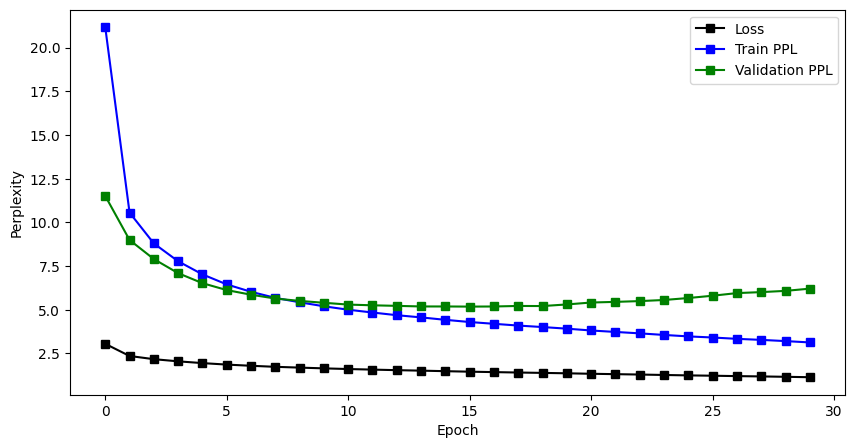

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(losses, 'ks-', label='Loss')
plt.plot(train_ppl, 'bs-', label='Train PPL')
plt.plot(val_ppl, 'gs-', label='Validation PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

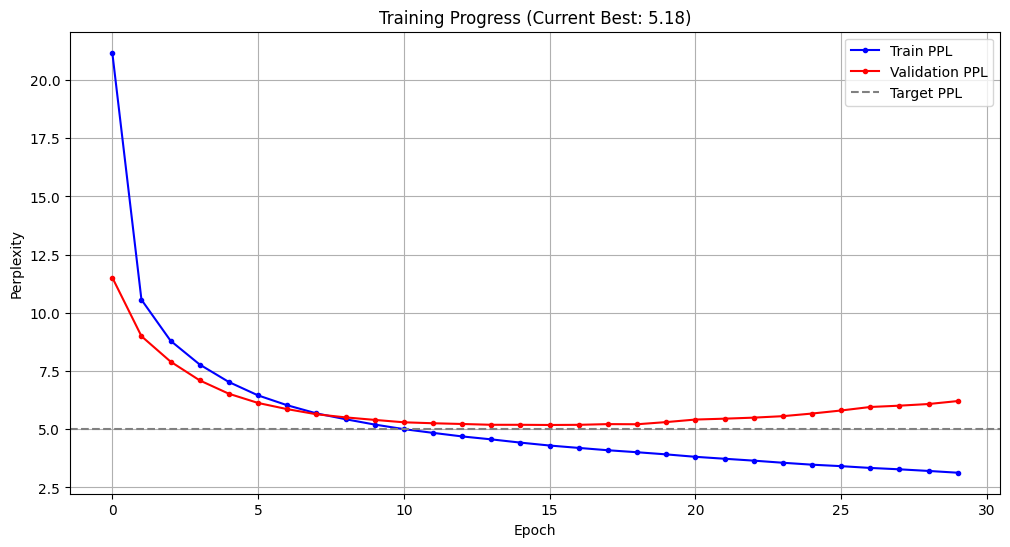

In [11]:
plt.figure(figsize=(12,6))
plt.plot(train_ppl, 'b.-', label='Train PPL')
plt.plot(val_ppl, 'r.-', label='Validation PPL')
plt.axhline(y=5.0, color='gray', linestyle='--', label='Target PPL')
plt.title('Training Progress (Current Best: {:.2f})'.format(min(val_ppl)))
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
test_loss = 0
test_chars = 0
hidden = None

model.eval()
with torch.no_grad():
    for i in range(0, test_data.size(0) - 1 - seq_len, seq_len):
        X = test_data[i:i+seq_len]
        y = test_data[i+1:i+1+seq_len].view(-1)
        
        y_hat, hidden = model(X, hidden)
        hidden = (hidden[0].detach(), hidden[1].detach())
        
        loss = criterion(y_hat.view(-1, model.vocab_size), y)
        test_loss += loss.item() * seq_len * BATCH_SIZE
        test_chars += seq_len * BATCH_SIZE

final_ppl = math.exp(test_loss / test_chars)
print(f'Final Test Perplexity: {final_ppl:.2f}')

Final Test Perplexity: 6.02


# No to dawaj mordo Mickiewicza

In [13]:
def generate_text(model, start_text, char_to_id, id_to_char, device, length=250):
    model.eval()
    
    char_ids = [char_to_id[char] for char in start_text]
    generated_text = start_text
    hidden = None
    
    for char_id in char_ids:
        current_char = torch.tensor([[char_id]], device=device)
        _, hidden = model(current_char, hidden)
    
    current_char = torch.tensor([[char_ids[-1]]], device=device)
    
    for _ in range(length):
        output, hidden = model(current_char, hidden)
        
        next_char_id = torch.argmax(output).item()
        
        current_char[0][0] = next_char_id
        generated_text += id_to_char[next_char_id]
    
    return generated_text

generate_text(model, "Litwo! Ojczyzno moja!", char_to_id, id_to_char, device, length=1000)

'Litwo! Ojczyzno moja!\r\n\r\n    W tej chwili w pole wyprawie młodzież o tym słowa\r\nI pod strzechy z wolna w pole wyprawie słońcem,\r\nA po chwili w pole idącego się szczytach,\r\nW końcu stał z przychodzi i z wolna pod strzechą,\r\nI po prawo stał pod niego po raz po raz po prawa.\r\nWidzisz szeroko z podejmie i stanął w powiecie,\r\nI pod nim stało w pole idącego szpadę,\r\nI po chwili w pole idącego się szczytach,\r\nW końcu stał z przychodzi i z wolna pod strzechą,\r\nI po prawo stał pod niego po raz po raz po prawa.\r\nWidzisz szeroko z podejmie i stanął w powiecie,\r\nI pod nim stało w pole idącego szpadę,\r\nI po chwili w pole idącego się szczytach,\r\nW końcu stał z przychodzi i z wolna pod strzechą,\r\nI po prawo stał pod niego po raz po raz po prawa.\r\nWidzisz szeroko z podejmie i stanął w powiecie,\r\nI pod nim stało w pole idącego szpadę,\r\nI po chwili w pole idącego się szczytach,\r\nW końcu stał z przychodzi i z wolna pod strzechą,\r\nI po prawo stał pod niego po raz

# And how does our Adam "write" while learning ?

In [16]:
pro = CharLSTM(vocab_size, embedding_size, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pro.parameters(), lr=learning_rate)

In [17]:
from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
    pro.train()
    hidden = None

    for i in range(0, train_data.size(0) - 1 - seq_len, seq_len):

        X = train_data[i:i+seq_len]
        y = train_data[i+1:i+1+seq_len].view(-1)
        

        optimizer.zero_grad()
        y_hat, hidden = pro(X, hidden)
        

        hidden = (hidden[0].detach(), hidden[1].detach())
        

        loss = criterion(y_hat.view(-1, vocab_size), y)
        
        loss.backward()
        optimizer.step()

    pro.eval()
    hidden = None
    
    with torch.no_grad():
        for i in range(0, valid_data.size(0) - 1 - seq_len, seq_len):
            X = valid_data[i:i+seq_len]
            y = valid_data[i+1:i+1+seq_len].view(-1)
            
            y_hat, hidden = pro(X, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            loss = criterion(y_hat.view(-1, vocab_size), y)

    if (epoch+1)%3==0:
        print(generate_text(pro, "Jam jest Jacek", char_to_id, id_to_char, device, length=350))


 10%|████████▎                                                                          | 3/30 [00:22<03:20,  7.43s/it]

Jam jest Jaceki,
I po strzele się z pod strzele się z pod pod pod pod pod pod wierzył,
I po strzele się z pod strzele się z pod pod pod pod pod pod wierzył,
I po strzele się z pod strzele się z pod pod pod pod pod pod wierzył,
I po strzele się z pod strzele się z pod pod pod pod pod pod wierzył,
I po strzele się z pod strzele się z pod pod pod pod pod pod w


 20%|████████████████▌                                                                  | 6/30 [00:43<02:53,  7.22s/it]

Jam jest Jaceki,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza się z powierzem w pole,
I z powierza się z powierza 


 30%|████████████████████████▉                                                          | 9/30 [01:04<02:32,  7.24s/it]

Jam jest Jaceka,
I po czym wielkie po strzelby za strony w pole,
I po czasu w pole w pole w pole w pole się z pole,
I po czasu w pole w pole w pole w pole się z pole,
I po czasu w pole w pole w pole w pole się z pole,
I po czasu w pole w pole w pole w pole się z pole,
I po czasu w pole w pole w pole w pole się z pole,
I po czasu w pole w pole w pole w pol


 40%|████████████████████████████████▊                                                 | 12/30 [01:26<02:09,  7.21s/it]

Jam jest Jaceki,
I po czasie wielkie za stołem za stołem w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pole w pole w pole,
I z powietrzu na pole w pol


 50%|█████████████████████████████████████████                                         | 15/30 [01:47<01:48,  7.25s/it]

Jam jest Jaceki — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski z powiecie — Wojski


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:09<01:27,  7.28s/it]

Jam jest Jaceki — Wojski z powietrze — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z powieście — Wojski z p


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:31<01:06,  7.35s/it]

Jam jest Jaceki,
W której pod stołu i z powietrzu na stodoły,
I po czasie starca na polowanie strony
I pod stołu i z powietrzu i strony wysłał,
I po czasie pod stołu i z powodu wybierzem.

    «Widzi się to za nim stał w powietrzu na stołu,
A w końcu podniósłszy od stołu i stoły,
I po czasie pod stołu i z powodu wybierzem.

    «Widzi się to za nim sta


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:53<00:44,  7.37s/it]

Jam jest Jaceka,
A widzi to nie wiedząc, wszystko się z powodu
I po cichu za szlachty i postać na koniec,
I po chwili wszystkich nie zaszkodził po kolei.

    W tej strony nie mogła nie wiedząc, że się z powiecie,
I po chwili wszystkich nie zaszkodził się z podoba.

    W tej strony nie mogła nie wiedząc, że się z powiecie,
I po chwili wszystkich nie za


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:14<00:21,  7.25s/it]

Jam jest Jaceki — Wojski z Soplicy!»

    «Więc — rzekł Sędzia — z powoli w końcu się zabierać,
A w tym zamku, a nie wiedząc, że się za stołem,
I po co też po co porządku i z podłożyć.

    Tadeusz z przeciwnik się z podobać się z pokoju.

    Tadeusz z przeciwnik się z podobać się z pokoju.

    Tadeusz z przeciwnik się z podobać się z pokoju.

    


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:35<00:00,  7.18s/it]

Jam jest Jacek —
Przerwał Sędzia — z panem Sędziego spodem złocie,
A wiesz co się też po co się z nim pod strzechy,
A w karczmach i strony nie zwierza obawił,
I po cichu za strzelby z niebytnością skłonił,
I po co to pani Telimena od stołu,
A w każdej powieść, które z powodu podniesiony,
I po co się z nim stało w pole, szczęśliwy do góry,
I z przyczyny S
